#**Early Dropout Detection Using Personalized Learning Data**
In this notebook, we’ll explore a personalized learning dataset (sourced from Kaggle) to build an early dropout detection system. The workflow will include:

- Data Import and Preprocessing: Handling missing values, encoding categorical data, and normalizing features.

- Exploratory Data Analysis (EDA): Understanding data distributions, identifying key patterns, and visualizing relationships that may influence dropout rates.

- Model Building: Applying a suitable machine learning model to predict the likelihood of a student dropping out based on personalized learning behaviors. The models that we used are Logistic Regression, Random Forest, Gradient Boosting, and CatBoost Classifier

- Model Evaluation: Assessing model performance using metrics like accuracy, precision, recall, and F1-score.

The objective is to create an interpretable and effective predictive model that can help proactively identify students at risk of leaving their courses.

# 1.0 Install and Import Libraries

In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import pickle

# 2.0 Data Loading

In [3]:
#df = pd.read_csv('/content/personalized_learning_dataset.csv')
#update code to import Kaggle data into Colab
#https://drive.google.com/file/d/1NVquw57ja4zLtCZvk25k4eFrz6laU-Qy/view?usp=sharing

!pip install -q gdown

file_id = '1NVquw57ja4zLtCZvk25k4eFrz6laU-Qy'
output_file = 'personalized_learning_dataset.csv'

!gdown --id {file_id} -O {output_file}
print("Download complete.")

df = pd.read_csv(output_file)

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NVquw57ja4zLtCZvk25k4eFrz6laU-Qy
To: /content/personalized_learning_dataset.csv
100% 837k/837k [00:00<00:00, 115MB/s]
Download complete.


In [4]:
# Summary of Dataset
print('Shape of Dataset: ', df.shape)
df.info()

Shape of Dataset:  (10000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Student_ID                  10000 non-null  object
 1   Age                         10000 non-null  int64 
 2   Gender                      10000 non-null  object
 3   Education_Level             10000 non-null  object
 4   Course_Name                 10000 non-null  object
 5   Time_Spent_on_Videos        10000 non-null  int64 
 6   Quiz_Attempts               10000 non-null  int64 
 7   Quiz_Scores                 10000 non-null  int64 
 8   Forum_Participation         10000 non-null  int64 
 9   Assignment_Completion_Rate  10000 non-null  int64 
 10  Engagement_Level            10000 non-null  object
 11  Final_Exam_Score            10000 non-null  int64 
 12  Learning_Style              10000 non-null  object
 13  Feedback_Score  

In [5]:
#Read the first five rows of the dataset
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


In [6]:
#Read the last five rows of the dataset
df.tail()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
9995,S09996,26,Female,Undergraduate,Machine Learning,162,2,87,27,73,Medium,68,Kinesthetic,2,No
9996,S09997,37,Male,Postgraduate,Machine Learning,447,2,39,10,68,Medium,46,Reading/Writing,1,Yes
9997,S09998,40,Female,Postgraduate,Machine Learning,105,4,50,23,41,High,64,Visual,1,No
9998,S09999,44,Male,High School,Python Basics,245,2,84,39,85,Medium,38,Visual,2,No
9999,S10000,39,Female,Undergraduate,Machine Learning,171,2,88,8,69,Medium,97,Visual,2,No


In [7]:
#Descriptive Statistics - Categorical Variable
summary_categorical = df.describe(include=['object'])
summary_categorical.loc['missing'] = df.isnull().sum()
summary_categorical


,Student_ID,Gender,Education_Level,Course_Name,Engagement_Level,Learning_Style,Dropout_Likelihood
count,10000,10000,10000,10000,10000,10000,10000
unique,10000,3,3,5,3,4,2
top,S09984,Female,Undergraduate,Machine Learning,Medium,Reading/Writing,No
freq,1,4886,5070,2043,4927,2554,8043
missing,0,0,0,0,0,0,0


In [8]:
#Descriptive Statistics (Numeric Variable)
summary_numeric=df.describe()
summary_numeric.loc['missing'] = df.isnull().sum()
summary_numeric

,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.137700,255.375400,2.500500,64.578600,24.616200,69.546800,64.697000,3.012600
std,10.062647,141.656392,1.122642,20.289125,14.330305,17.360782,20.096417,1.421423
min,15.000000,10.000000,1.000000,30.000000,0.000000,40.000000,30.000000,1.000000
25%,24.000000,131.000000,1.000000,47.000000,12.000000,54.000000,47.000000,2.000000
50%,32.000000,257.000000,3.000000,65.000000,25.000000,69.000000,65.000000,3.000000
75%,41.000000,378.000000,4.000000,82.000000,37.000000,85.000000,82.000000,4.000000
max,49.000000,499.000000,4.000000,99.000000,49.000000,99.000000,99.000000,5.000000
missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 2.0 Data Cleaning

In [9]:
# Checking for missing values within data
df.isnull().sum()

,0
Student_ID,0
Age,0
Gender,0
Education_Level,0
Course_Name,0
Time_Spent_on_Videos,0
Quiz_Attempts,0
Quiz_Scores,0
Forum_Participation,0
Assignment_Completion_Rate,0


In [10]:
#Checking Skewness of Numerical Data
df.skew(numeric_only=True).sort_values(ascending=False)

,0
Assignment_Completion_Rate,0.013916
Final_Exam_Score,-0.003571
Quiz_Attempts,-0.007399
Feedback_Score,-0.009044
Quiz_Scores,-0.009049
Forum_Participation,-0.014128
Time_Spent_on_Videos,-0.018043
Age,-0.023052


In [11]:
#Checking for duplicates within data
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [12]:
#Checking for outliers within data using IQR method

# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Store results
outlier_summary = {}

# Loop through columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)

# Convert to DataFrame for readability
outlier_counts = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_counts = outlier_counts.sort_values(by='Outlier Count', ascending=False)
outlier_counts

,Outlier Count
Age,0
Time_Spent_on_Videos,0
Quiz_Attempts,0
Quiz_Scores,0
Forum_Participation,0
Assignment_Completion_Rate,0
Final_Exam_Score,0
Feedback_Score,0


In [13]:
#To perform category consolidation/reduction on the 'Gender' column
#Merge the 'Other' into the mode of the 'Gender' column

#Replacing 'Other' values to NaN
df.loc[df['Gender'] == 'Other', 'Gender'] = np.nan

#Imputing the NaN values to the mode of the column
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

/tmp/ipython-input-13-3718474876.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


In [14]:
#Drop 'Student_ID' column
df=df.drop(['Student_ID'],axis=1)

In [15]:
# Resampling Age Distributions based on Education Levels
mask_high_school = (df["Education_Level"] == "High School") & (df["Age"] > 17)
mask_undergraduate = (df["Education_Level"] == "Undergraduate") & (df["Age"] < 18)
mask_postgraduate = (df["Education_Level"] == "Postgraduate") & (df["Age"] < 18)

# Generate random ages between 13 and 17 (inclusive) for those high school records
df.loc[mask_high_school, "Age"] = np.random.randint(13, 18, size=mask_high_school.sum())

# Generate random ages between 18 and 50 (inclusive) for Undergraduate records
df.loc[mask_undergraduate, "Age"] = np.random.randint(18, 50, size=mask_undergraduate.sum())

# Generate random ages between 18 and 50 (inclusive) for those Postgraduate records
df.loc[mask_postgraduate, "Age"] = np.random.randint(18, 50, size=mask_postgraduate.sum())


In [16]:
#Final DataFrame after Data Cleaning
print("Shape of Dataset: ", df.shape)
df

Shape of Dataset:  (10000, 14)


,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26,Female,Undergraduate,Machine Learning,162,2,87,27,73,Medium,68,Kinesthetic,2,No
9996,37,Male,Postgraduate,Machine Learning,447,2,39,10,68,Medium,46,Reading/Writing,1,Yes
9997,40,Female,Postgraduate,Machine Learning,105,4,50,23,41,High,64,Visual,1,No
9998,16,Male,High School,Python Basics,245,2,84,39,85,Medium,38,Visual,2,No


# 3.0 Data Exploration (EDA)

## 3.1 Univariate Analysis

<Axes: xlabel='Gender'>

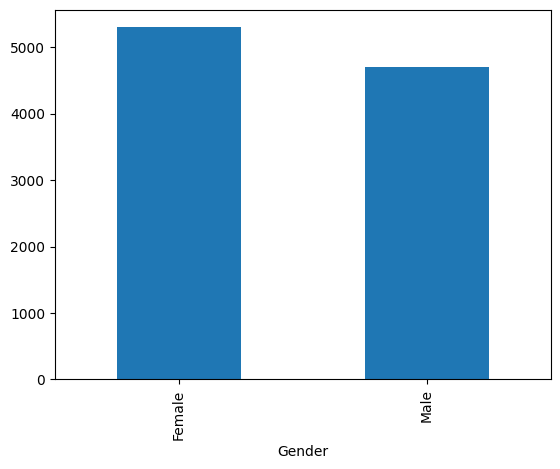

In [17]:
df['Gender'].value_counts().plot(kind='bar')

<Axes: xlabel='Learning_Style'>

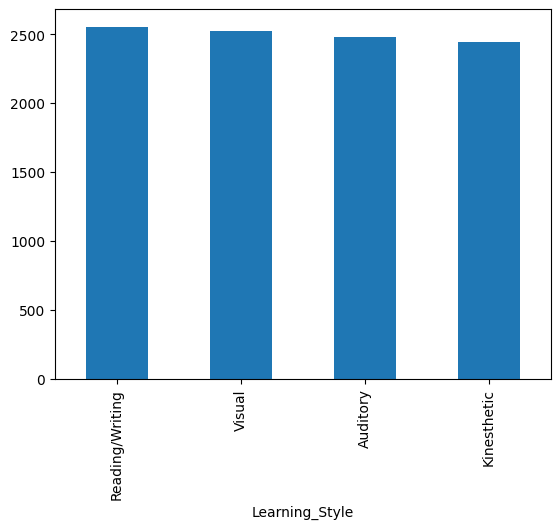

In [18]:
df['Learning_Style'].value_counts().plot(kind='bar')

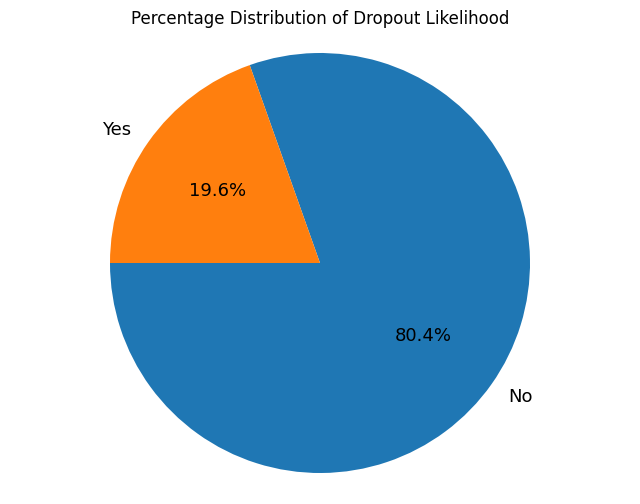

In [19]:
# Calculate percentage for each category
DropoutLikelihood_counts = df['Dropout_Likelihood'].value_counts()
labels = DropoutLikelihood_counts.index
sizes = DropoutLikelihood_counts.values

# Plotting a pie chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180, textprops={'fontsize': 13})
plt.title('Percentage Distribution of Dropout Likelihood')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

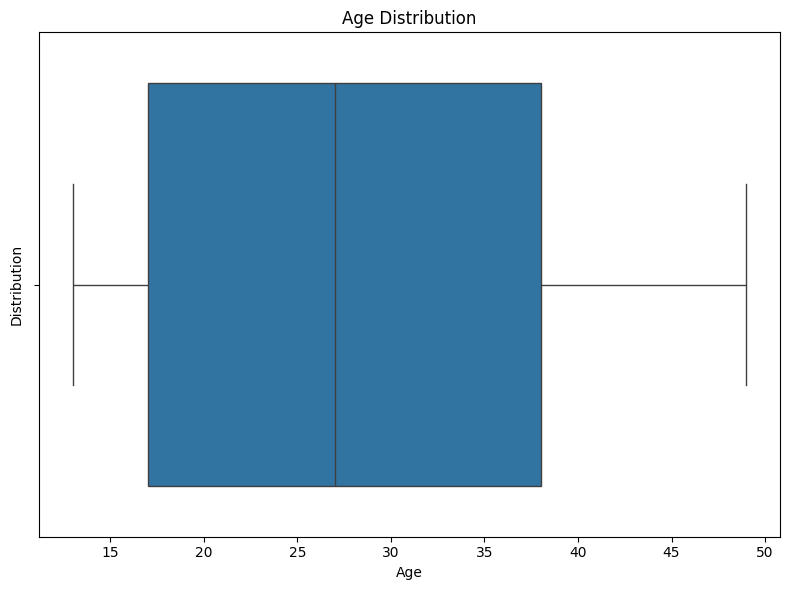

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Age')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Distribution')
plt.tight_layout()
plt.show()

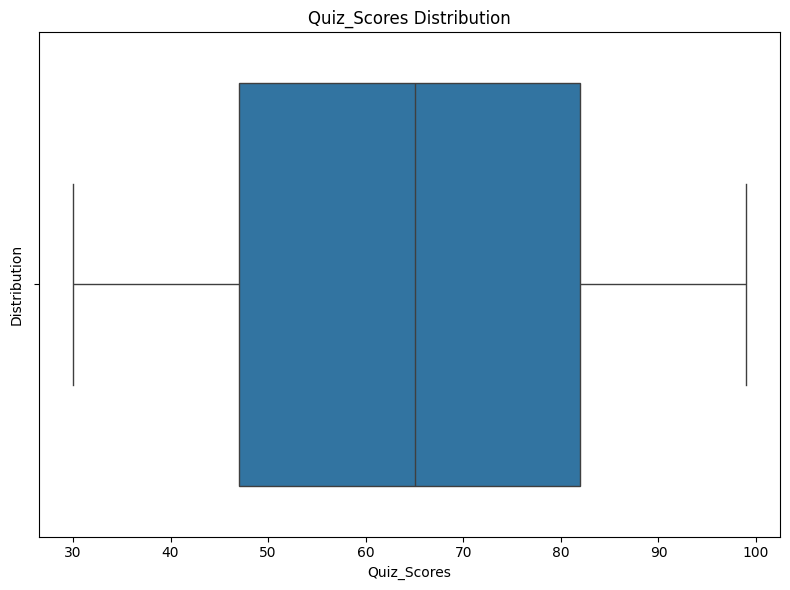

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Quiz_Scores')
plt.title('Quiz_Scores Distribution')
plt.xlabel('Quiz_Scores')
plt.ylabel('Distribution')
plt.tight_layout()
plt.show()

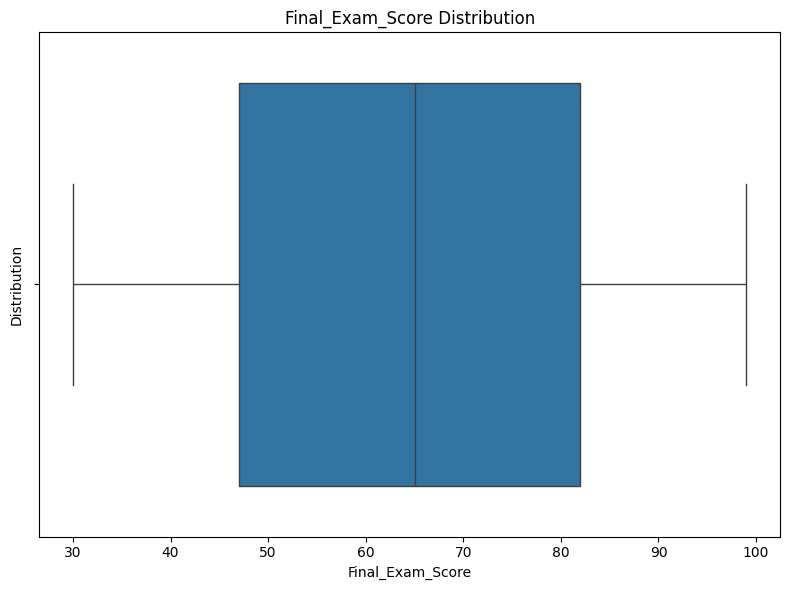

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Final_Exam_Score')
plt.title('Final_Exam_Score Distribution')
plt.xlabel('Final_Exam_Score')
plt.ylabel('Distribution')
plt.tight_layout()
plt.show()

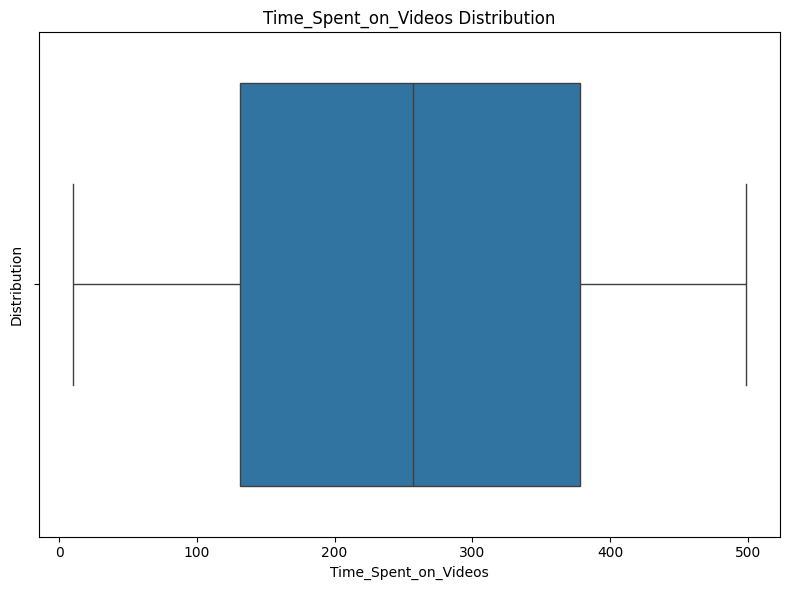

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Time_Spent_on_Videos')
plt.title('Time_Spent_on_Videos Distribution')
plt.xlabel('Time_Spent_on_Videos')
plt.ylabel('Distribution')
plt.tight_layout()
plt.show()

## 3.2 Bivariate Analysis

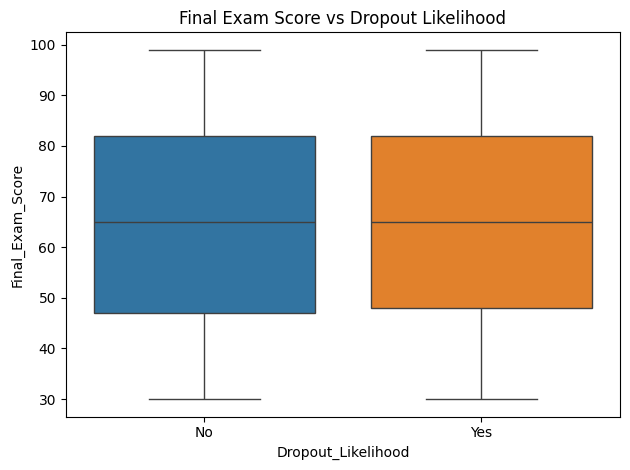

In [24]:
sns.boxplot(data=df, x='Dropout_Likelihood', y='Final_Exam_Score', hue='Dropout_Likelihood')
plt.title('Final Exam Score vs Dropout Likelihood')
plt.tight_layout()
plt.show()

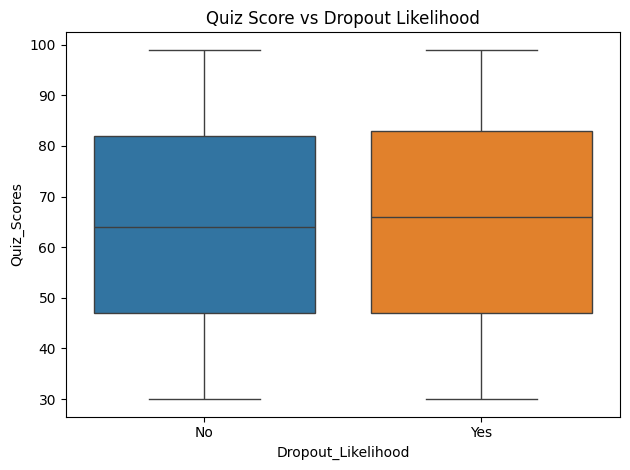

In [25]:
sns.boxplot(data=df, x='Dropout_Likelihood', y='Quiz_Scores', hue='Dropout_Likelihood')
plt.title('Quiz Score vs Dropout Likelihood')
plt.tight_layout()
plt.show()

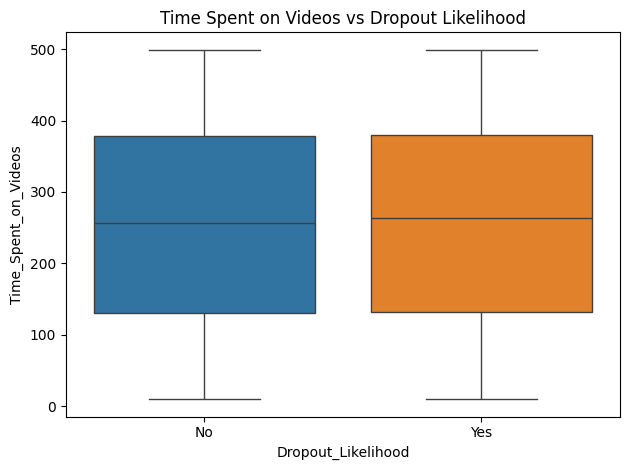

In [26]:
sns.boxplot(data=df, x='Dropout_Likelihood', y='Time_Spent_on_Videos', hue='Dropout_Likelihood')
plt.title('Time Spent on Videos vs Dropout Likelihood')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Gender vs Dropout Likelihood')

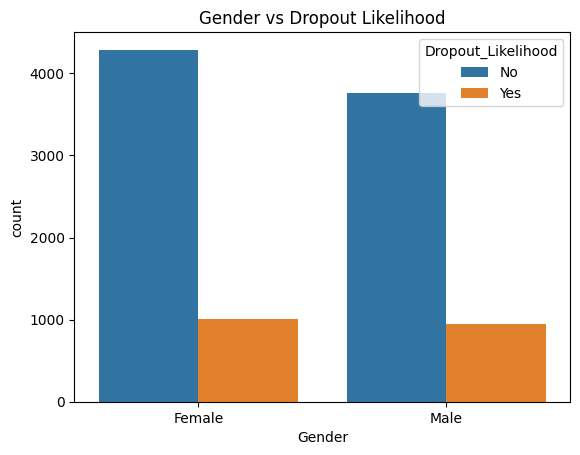

In [27]:
sns.countplot(data=df, x='Gender', hue='Dropout_Likelihood')
plt.title('Gender vs Dropout Likelihood')

<Axes: xlabel='Education_Level'>

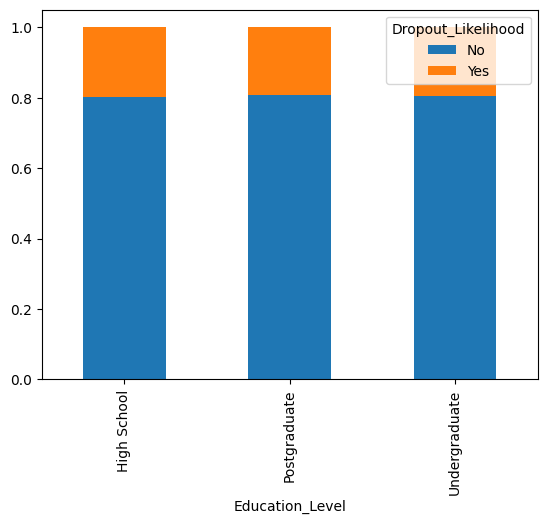

In [28]:
pd.crosstab(df['Education_Level'], df['Dropout_Likelihood'], normalize='index').plot(kind='bar', stacked=True)

Text(0.5, 1.0, 'Gender vs Dropout Likelihood')

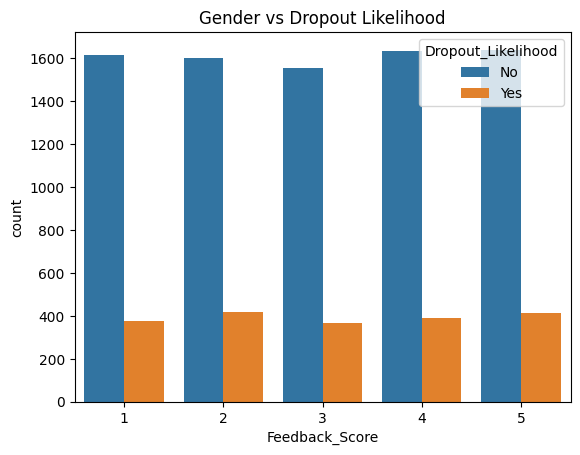

In [29]:
sns.countplot(data=df, x='Feedback_Score', hue='Dropout_Likelihood')
plt.title('Gender vs Dropout Likelihood')

[Text(0.5, 1.0, 'Dropout Likelihood by Engagement Level')]

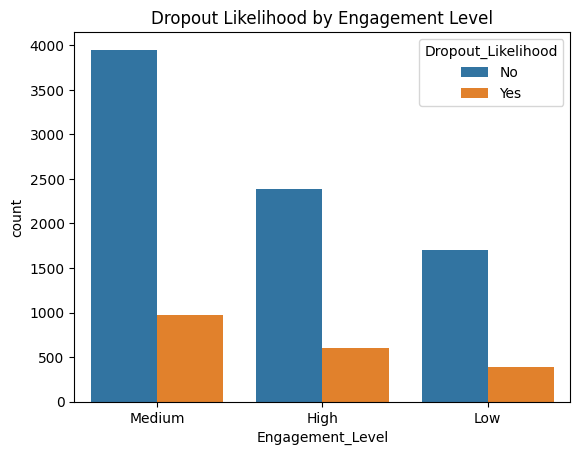

In [30]:
sns.countplot(data=df, x="Engagement_Level", hue="Dropout_Likelihood").set(title='Dropout Likelihood by Engagement Level')

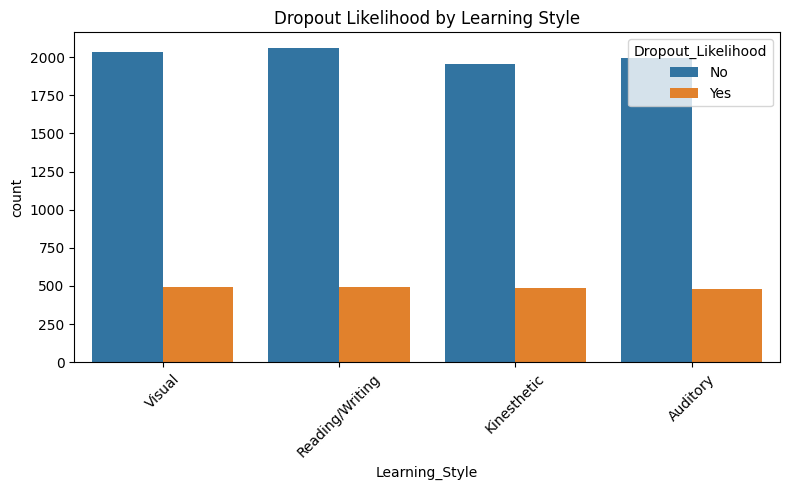

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Learning_Style', hue='Dropout_Likelihood')
plt.title('Dropout Likelihood by Learning Style')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
print(df.columns)

Index(['Age', 'Gender', 'Education_Level', 'Course_Name',
       'Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores',
       'Forum_Participation', 'Assignment_Completion_Rate', 'Engagement_Level',
       'Final_Exam_Score', 'Learning_Style', 'Feedback_Score',
       'Dropout_Likelihood'],
      dtype='object')


## 3.3 Multivariate Analysis

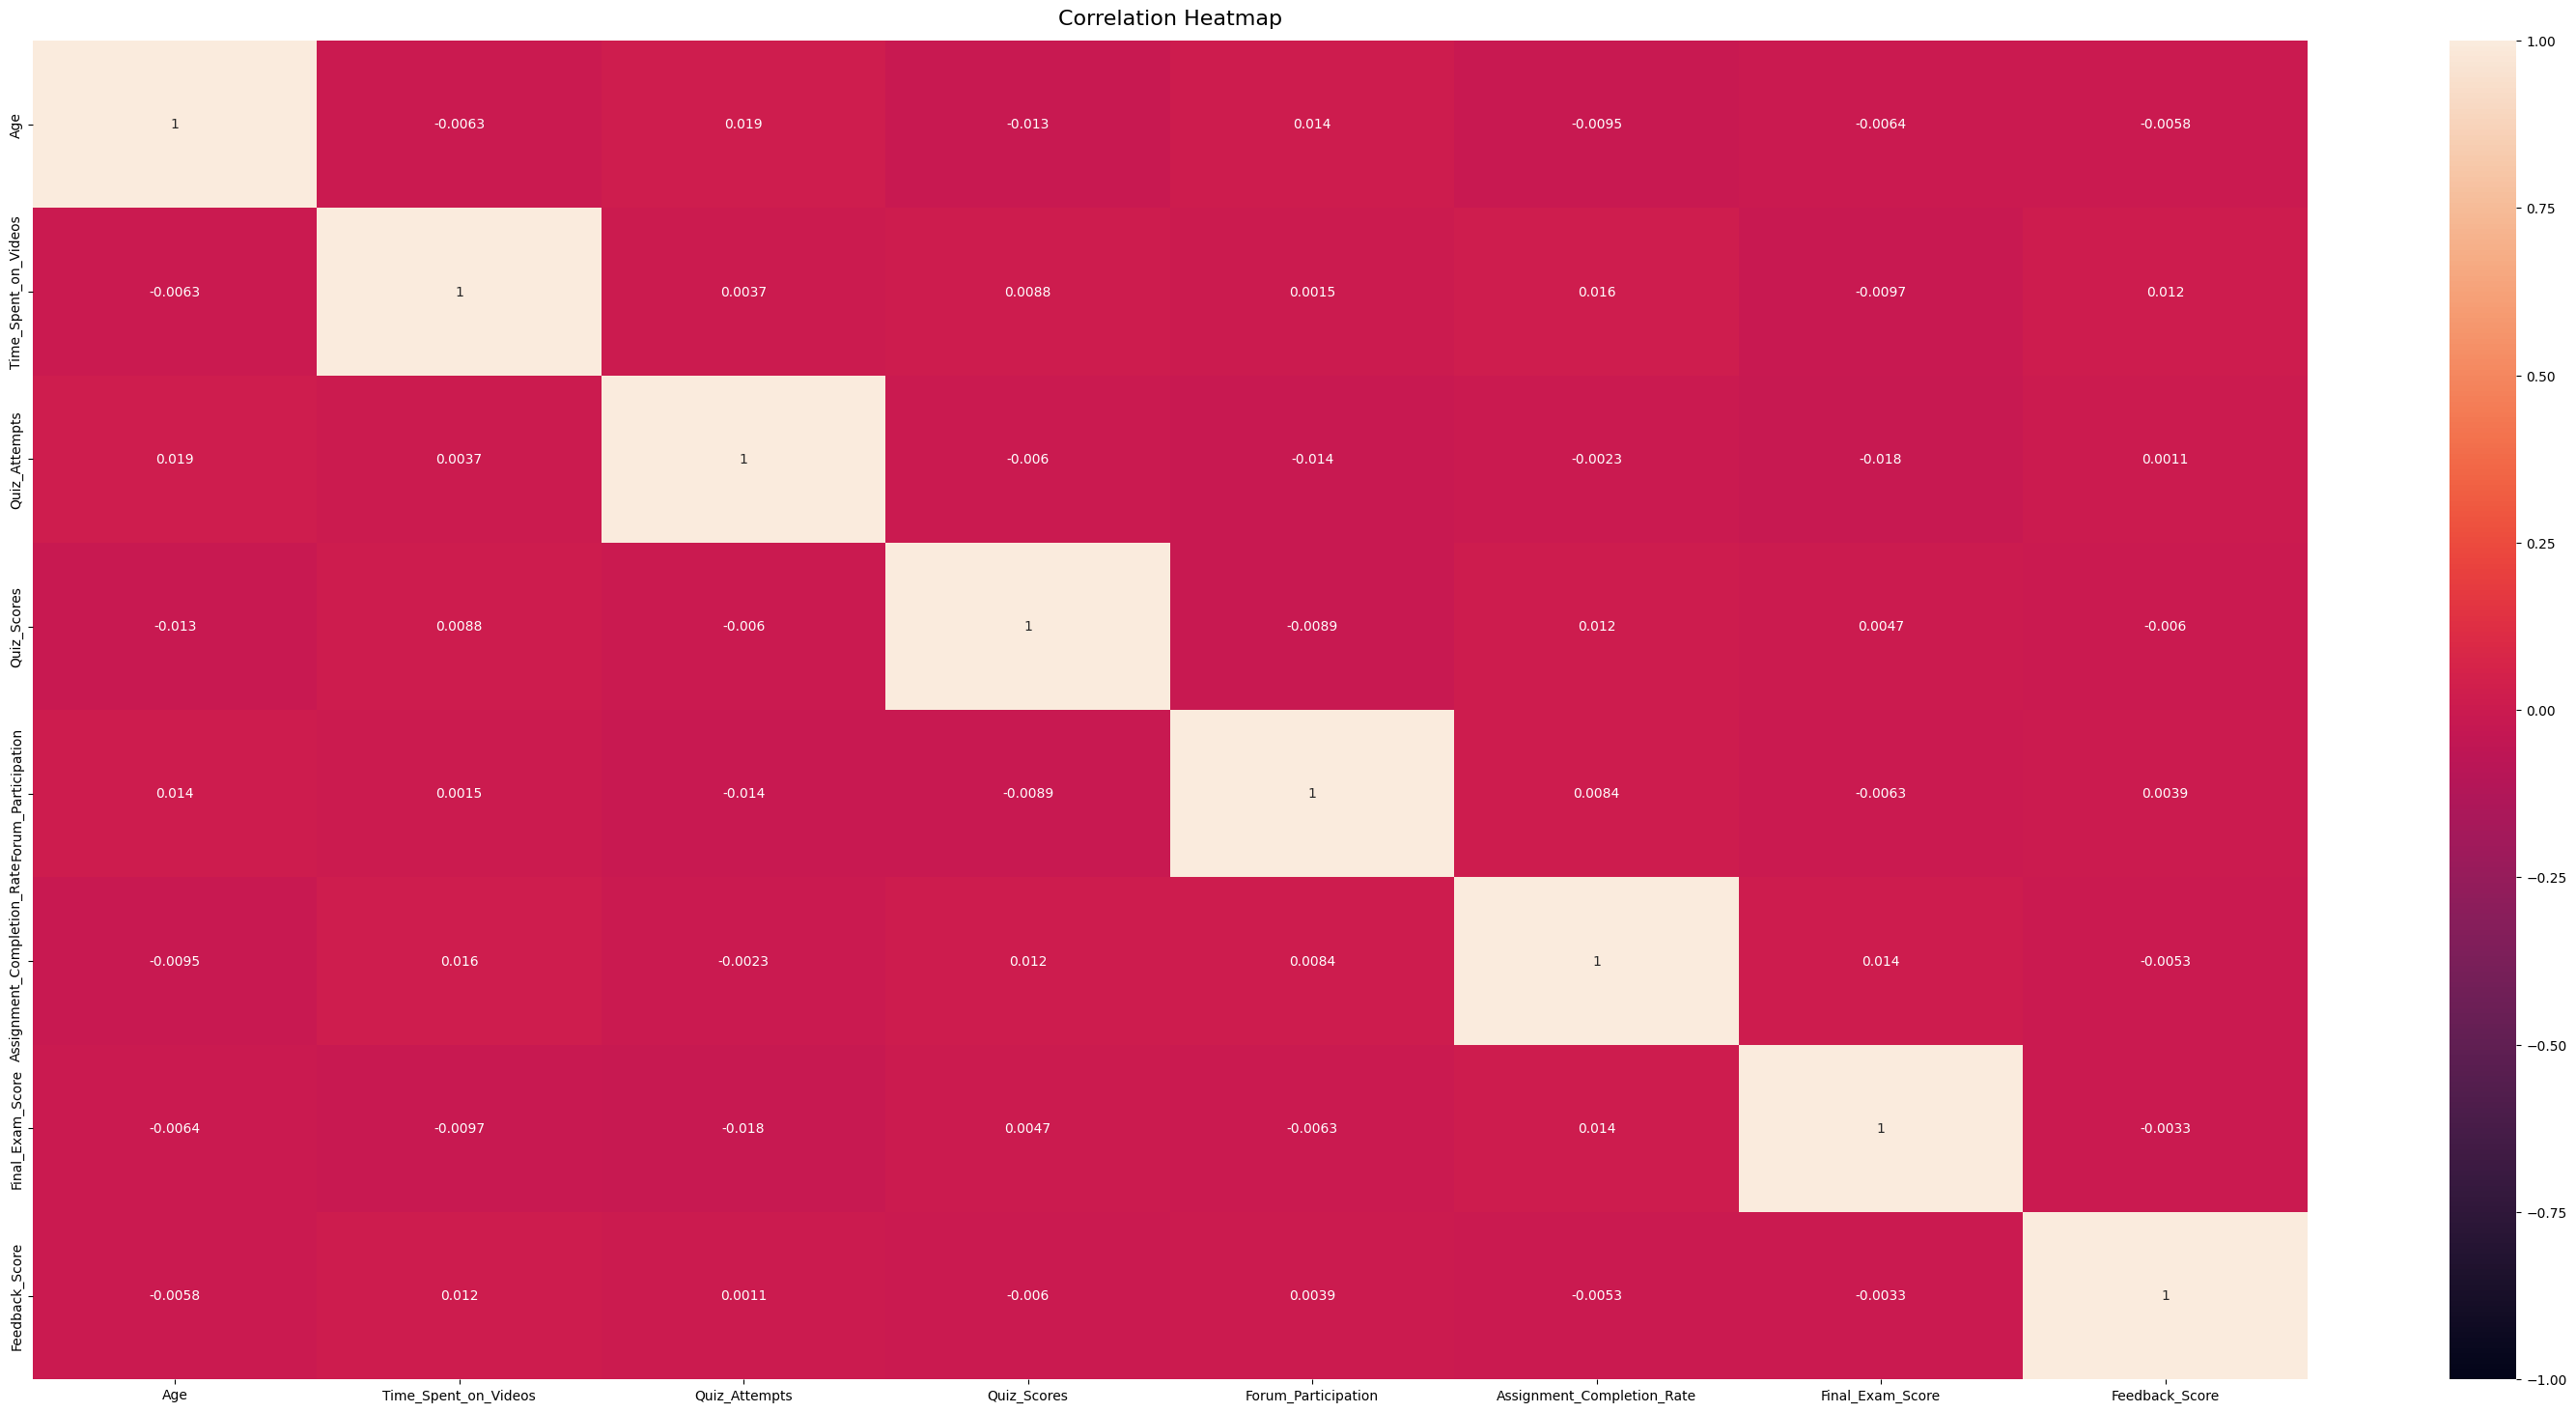

In [33]:
# Increase the size of the heatmap.
plt.figure(figsize=(38, 18))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

# 4.0 Feature Engineering

In [34]:
#Deriving New Features

# Avoid division by zero
df['Quiz_Efficiency'] = df['Quiz_Scores'] / df['Quiz_Attempts'].replace(0, np.nan)
df['High_Performer'] = df['Final_Exam_Score'] > 85.


# Activity level - average of forum, video time, and assignments
df['Activity_Level_Avg'] = (
    df['Time_Spent_on_Videos'] +
    df['Forum_Participation'] +
    df['Assignment_Completion_Rate']
) / 3


# Completion and performance ratio
df['Completion_Performance_Score'] = (
    df['Assignment_Completion_Rate'] / 100
) * (df['Quiz_Scores'] / 100)

df['Performance_Score'] = (
    (df['Assignment_Completion_Rate'] >= 90).astype(int) +
    (df['Quiz_Scores'] >= 80).astype(int) +
    (df['Final_Exam_Score'] >= 85).astype(int) +
    (df['Engagement_Level'] == 'High').astype(int) +
    (df['Feedback_Score'] >= 80).astype(int)
)

df['High_Performer'] = df['Performance_Score'] >= 4


# Learning efficiency (score relative to effort)
df['Learning_Efficiency'] = df['Final_Exam_Score'] / (
    df['Time_Spent_on_Videos'] + df['Quiz_Attempts'] + 1  # Avoid division by zero
)

# Binary Flags
df['Low_Assignment_Completion'] = df['Assignment_Completion_Rate'] < 50
df['Low_Quiz_Score'] = df['Quiz_Scores'] < 50
df['Low_Forum_Participation'] = df['Forum_Participation'] == 0
df['Low_Video_Watch_Time'] = df['Time_Spent_on_Videos'] < df['Time_Spent_on_Videos'].median()
df['Low_Final_Exam_Score'] = df['Final_Exam_Score'] < 50
df['Negative_Feedback'] = df['Feedback_Score'] < 3
df['Low_Engagement'] = df['Engagement_Level'] == 'Low'


# Age groups
df['Is_Young'] = df['Age'] < 25
df['Is_Senior'] = df['Age'] >= 40


#Composite Risk Score
df['Dropout_Risk_Score'] = (
    df['Low_Assignment_Completion'].astype(int) +
    df['Low_Quiz_Score'].astype(int) +
    df['Low_Forum_Participation'].astype(int) +
    df['Low_Final_Exam_Score'].astype(int) +
    df['Negative_Feedback'].astype(int)
)


In [35]:
## One-Hot Encoding for Categorical Fields
one_hot_cols = ['Gender', 'Course_Name', 'Learning_Style']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


## Ordinal Encoding for Ordinal Fields
ordinal_cols = ['Education_Level', 'Engagement_Level']
ordinal_mappings = {
    'Education_Level': ['High School', 'Undergraduate', 'Postgraduate'],
    'Engagement_Level': ['Low', 'Medium', 'High']
}

ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])


## Label Encoding for Target Fields
label_encoder = LabelEncoder()
df['Dropout_Likelihood'] = label_encoder.fit_transform(df['Dropout_Likelihood'])

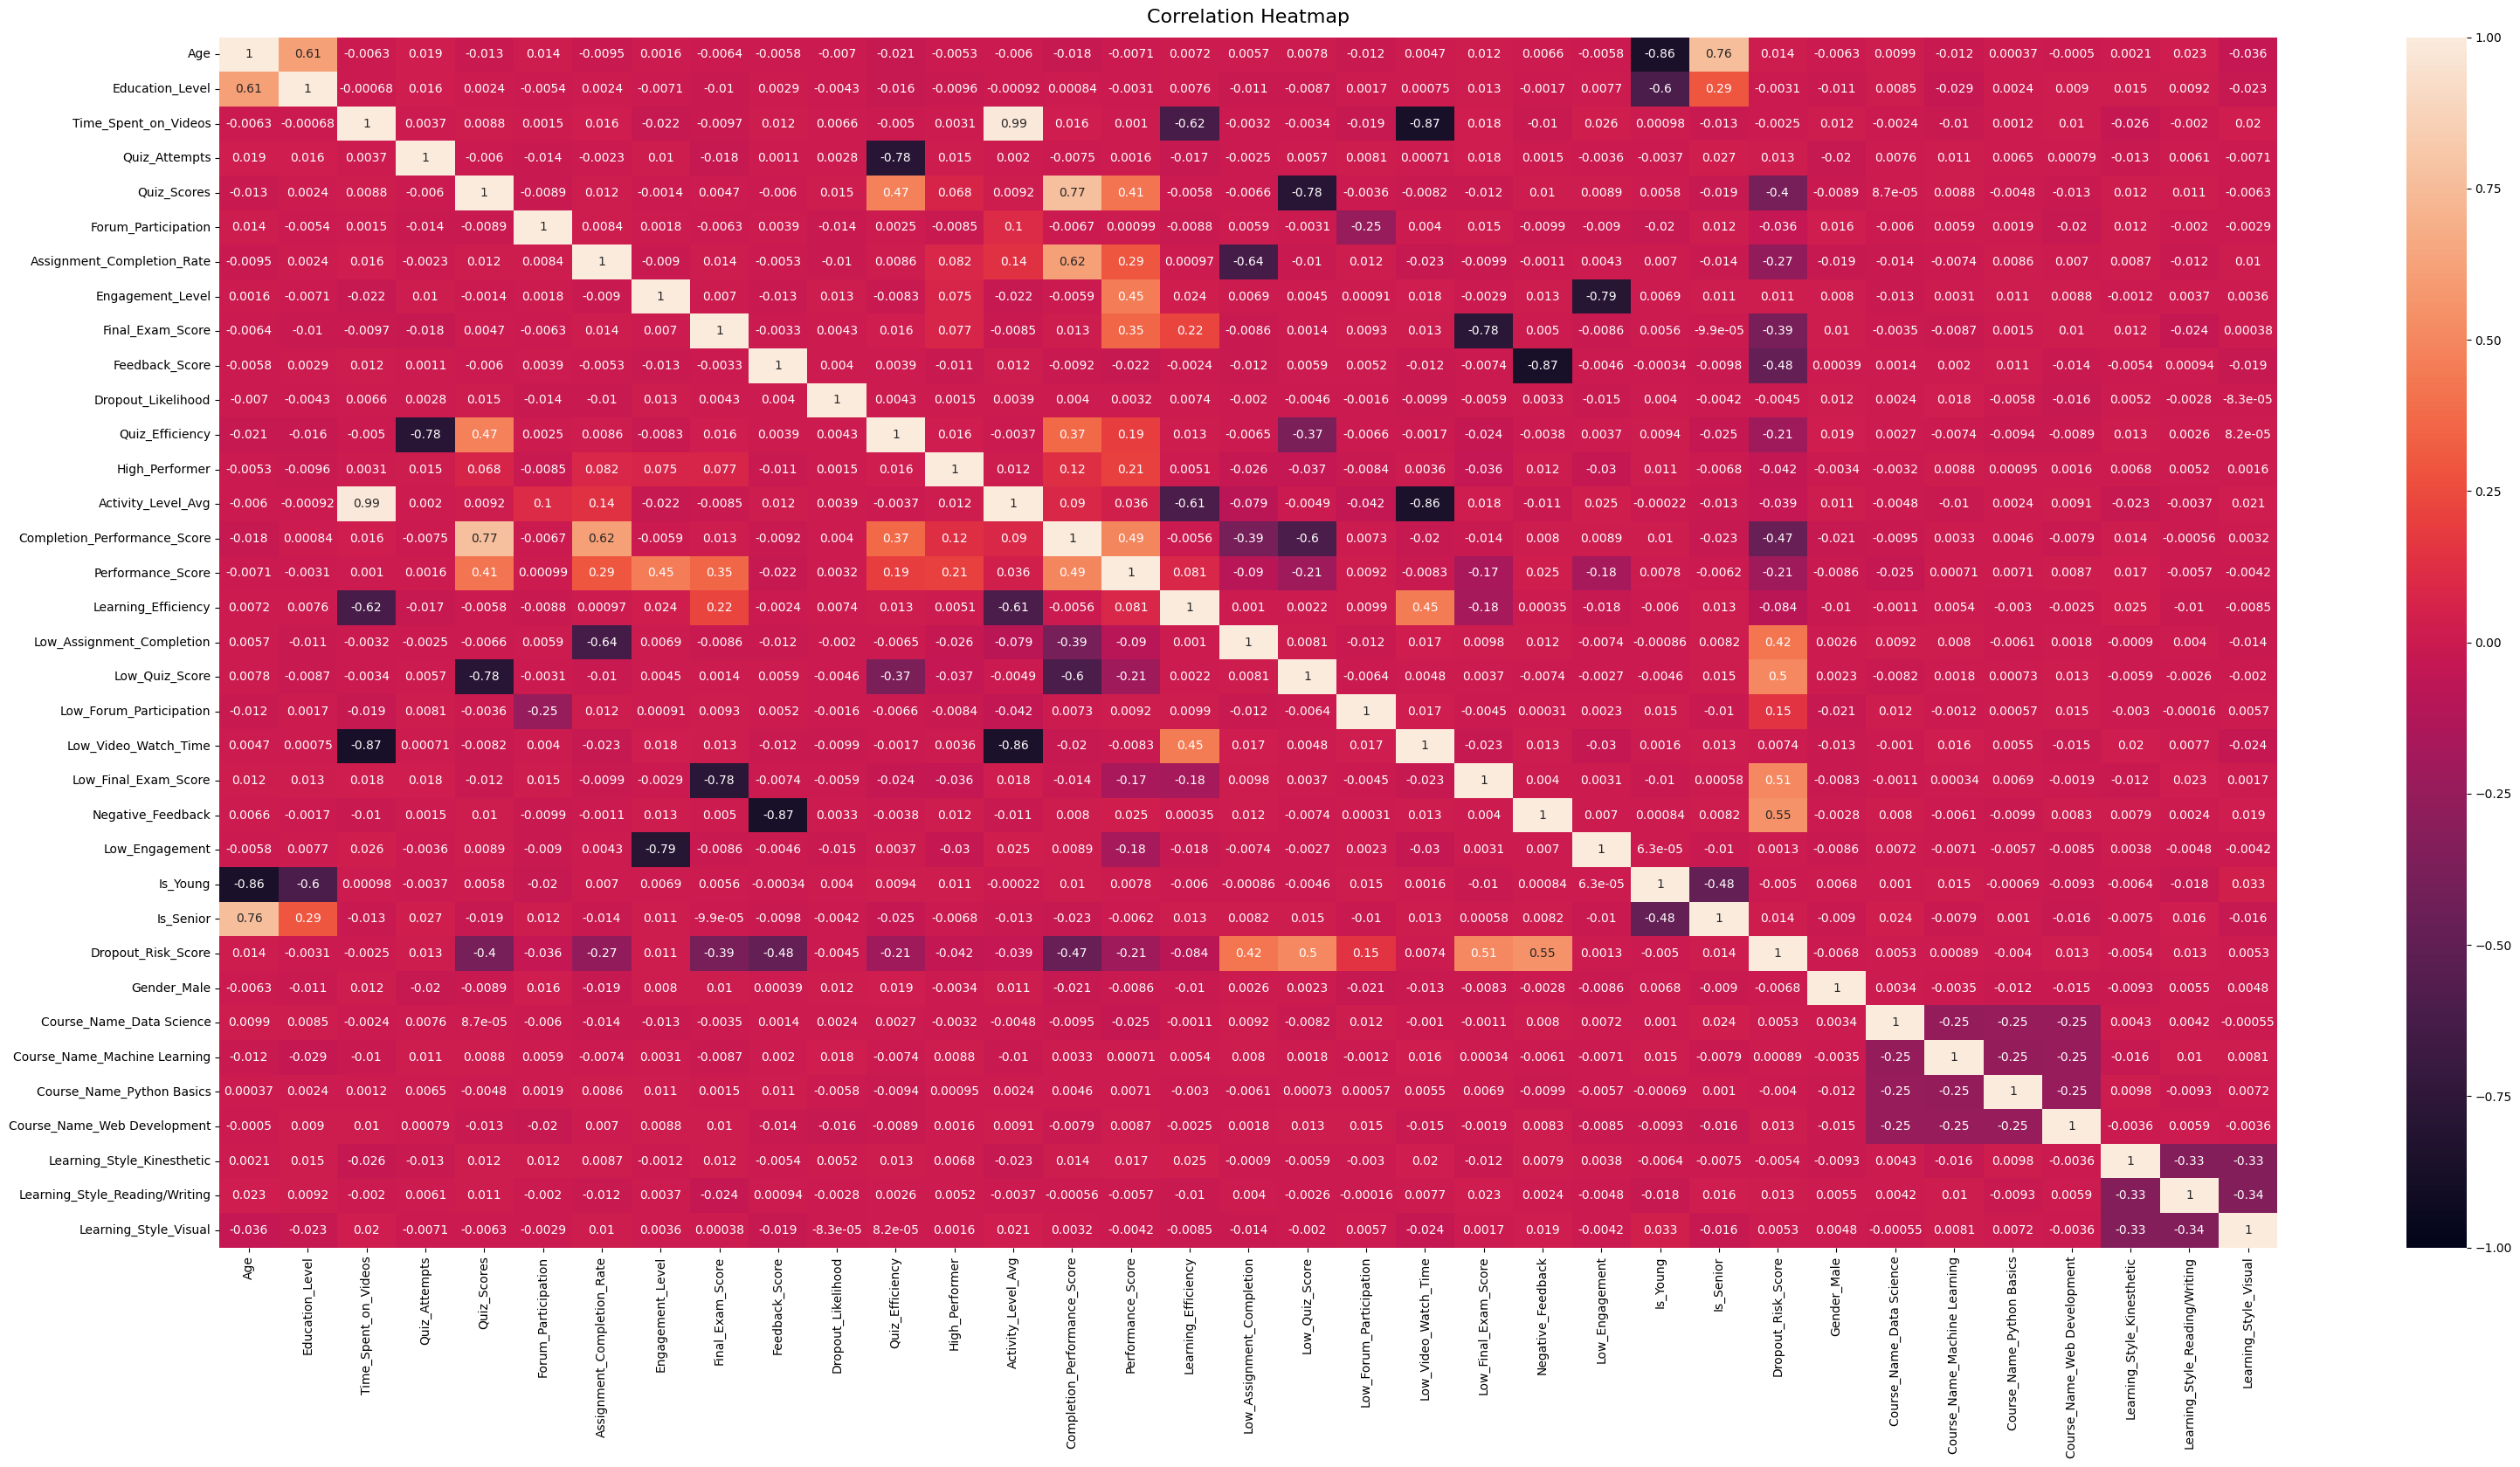

In [36]:
# Increase the size of the heatmap.
plt.figure(figsize=(38, 18))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

In [37]:
#Feature Selection
#(Age, Quiz_Scores, Forum_Participation, Assignment_Completion_Rate, Engagement_Level, Learning_Efficiency, Low_Video_Watch_Time
#Low_Final_Exam_Score, Low_Engagement, Is_Young, Is_Senior, Gender_Male, Course_Name_Data_Science, Course_Name_Machine_Learning,
#Course_Name_Python_Basics, Course_Name_Web_Development)

df=df.drop(['Quiz_Efficiency','High_Performer','Activity_Level_Avg', 'Completion_Performance_Score'],axis=1)
df=df.drop(['Low_Assignment_Completion', 'Low_Quiz_Score', 'Low_Forum_Participation'],axis=1)
df=df.drop(['Negative_Feedback','Dropout_Risk_Score'],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10000 non-null  int64  
 1   Education_Level                 10000 non-null  float64
 2   Time_Spent_on_Videos            10000 non-null  int64  
 3   Quiz_Attempts                   10000 non-null  int64  
 4   Quiz_Scores                     10000 non-null  int64  
 5   Forum_Participation             10000 non-null  int64  
 6   Assignment_Completion_Rate      10000 non-null  int64  
 7   Engagement_Level                10000 non-null  float64
 8   Final_Exam_Score                10000 non-null  int64  
 9   Feedback_Score                  10000 non-null  int64  
 10  Dropout_Likelihood              10000 non-null  int64  
 11  Performance_Score               10000 non-null  int64  
 12  Learning_Efficiency             1

# 5.0 Data Modelling

<Axes: xlabel='Dropout_Likelihood', ylabel='count'>

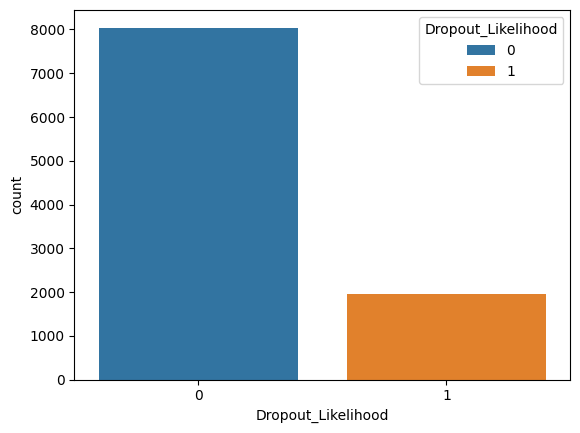

In [38]:
#Check for Target Imbalance (Unbalanced Dataset)
df['Dropout_Likelihood'].value_counts()
sns.countplot(data=df, x='Dropout_Likelihood', hue='Dropout_Likelihood')

In [39]:
#Define Predictor DF (x) and Target DF (y)
x=df.drop(['Dropout_Likelihood'],axis=1)
y=df['Dropout_Likelihood']

In [40]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3, random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)


y.value_counts()

,count
Dropout_Likelihood,
0,8043
1,1957


In [42]:
# Scale the features for logistic regression only
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [43]:

# saved feature columns during training
with open('feature_columns.pkl', 'wb') as f:
  pickle.dump(list(x_train.columns), f)

##**Logistic Regression**

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

# Set up the grid search
model = LogisticRegression(max_iter=1000)
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to training data
grid.fit(x_train_scaled, y_train)

# Best parameters and score
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.756073515809233



Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1609
           1       0.20      0.20      0.20       391

    accuracy                           0.69      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.69      0.69      0.69      2000

0.6885
AUC-ROC Score: 0.5053471600762336


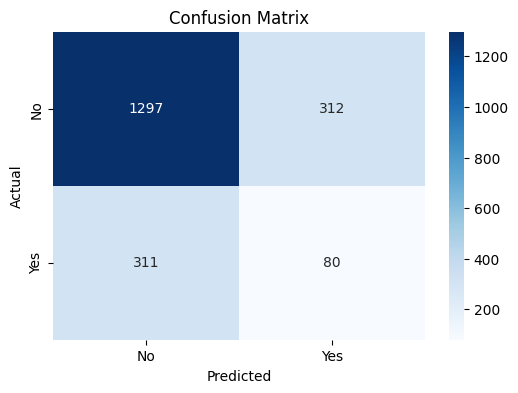

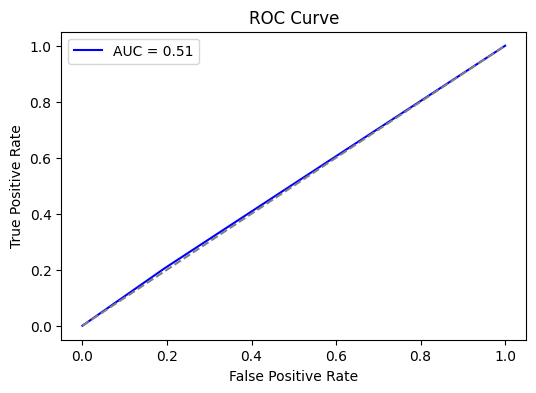

In [45]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    C=1,             # Regularization strength
    penalty='l1',      # Type of regularization
    solver='liblinear',# Solver that supports 'l1'
    max_iter=1000)

model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

print("\nClassification Report:\n",classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", roc_auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#save model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(model, f)

#Feature Importance
#importance = pd.Series(model.coef_[0], index=df)
#importance.sort_values().plot(kind='barh', title='Feature Importance (Logistic Coefficients)')
#plt.xlabel('Coefficient Value')
#plt.show()


##**Random Forest**


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      1609
           1       0.22      0.01      0.02       391

    accuracy                           0.80      2000
   macro avg       0.51      0.50      0.45      2000
weighted avg       0.69      0.80      0.72      2000

0.7995
AUC-ROC Score: 0.5007645612356327


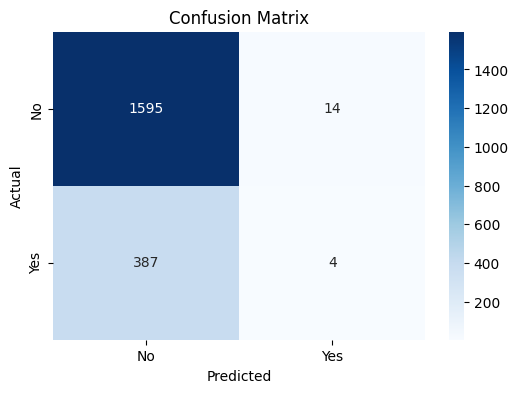

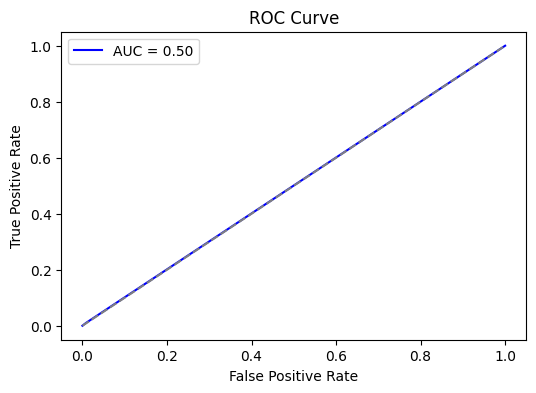

In [46]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]
print("\nClassification Report:\n",classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", roc_auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#save model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(model, f)

##**Gradient Boosting**


Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1609
           1       0.00      0.00      0.00       391

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000

0.804
AUC-ROC Score: 0.4996892479801119


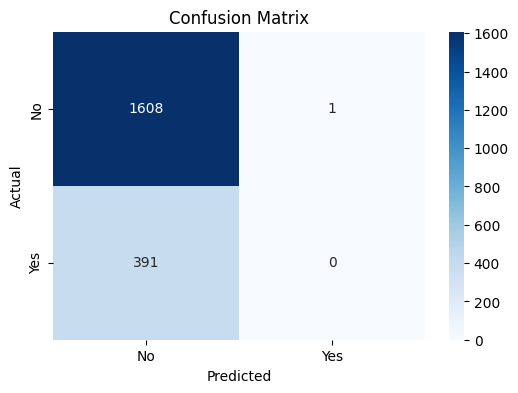

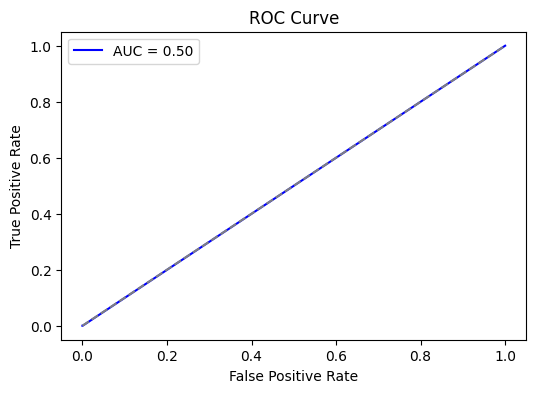

In [47]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]
print("\nClassification Report:\n",classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", roc_auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#save model
with open('gb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

##**CatBoost Classifier**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1609
           1       0.25      0.01      0.01       391

    accuracy                           0.80      2000
   macro avg       0.53      0.50      0.45      2000
weighted avg       0.70      0.80      0.72      2000

0.8025
AUC-ROC Score: 0.5006930326377045


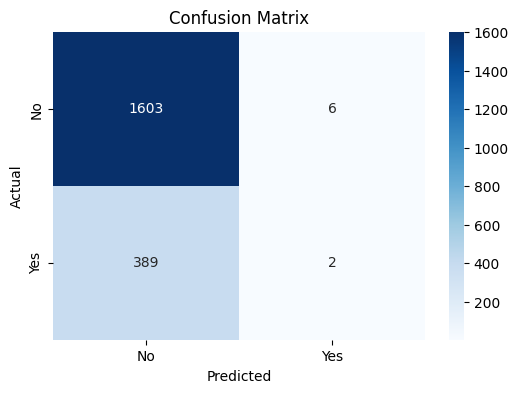

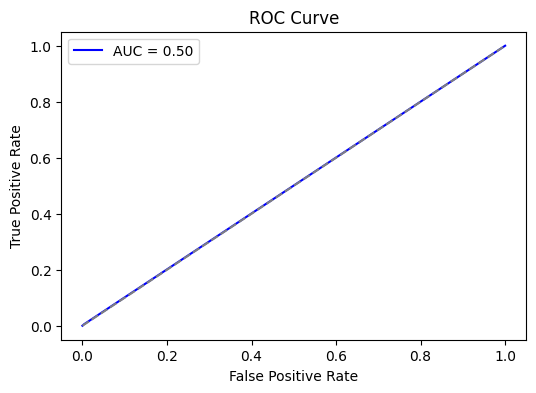

In [48]:
!pip install catboost
from catboost import CatBoostClassifier


model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]
print("\nClassification Report:\n",classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", roc_auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#save model
with open('cb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

/tmp/ipython-input-49-2725174777.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')


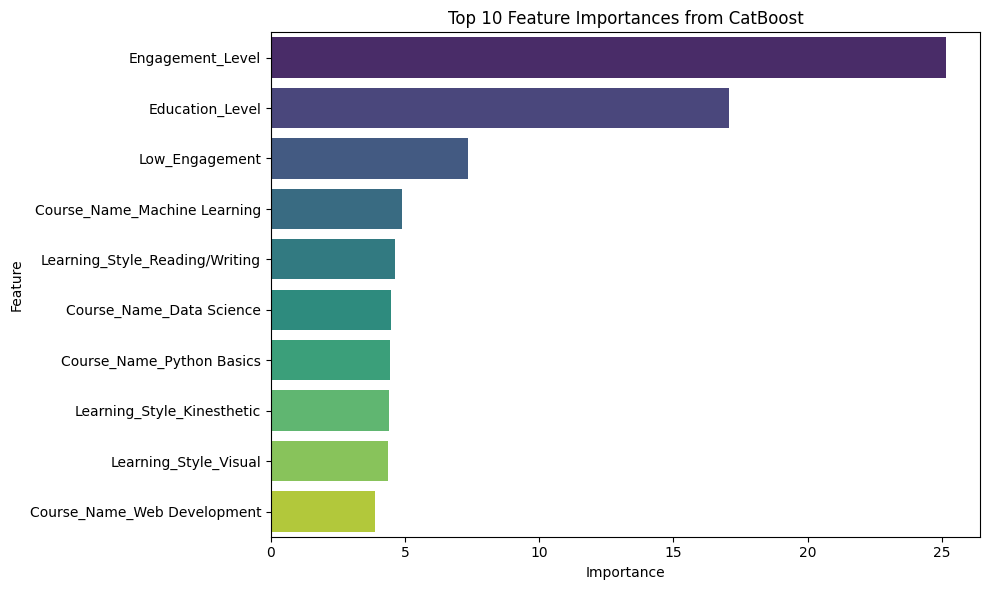

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.get_feature_importance()
feature_names = x_test.columns  # assuming x_train is a DataFrame

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances from CatBoost')
plt.tight_layout()
plt.show()


## VALIDATION SUMMARY

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



🔍 Validation Summary:

                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0             CatBoost     0.802      0.250   0.005     0.010    0.494
1    Gradient Boosting     0.804      0.000   0.000     0.000    0.508
2  Logistic Regression     0.196      0.196   1.000     0.327    0.497
3        Random Forest     0.800      0.222   0.010     0.020    0.497


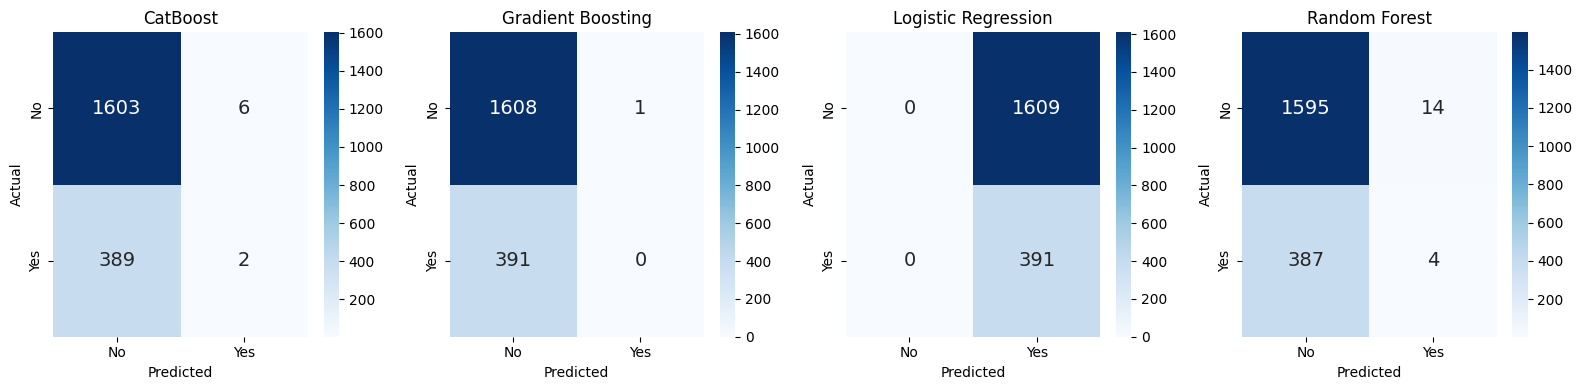

In [50]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, confusion_matrix
)

# Define model filenames
model_files = {
    "CatBoost": "cb_model.pkl",
    "Gradient Boosting": "gb_model.pkl",
    "Logistic Regression": "lr_model.pkl",
    "Random Forest": "rf_model.pkl"
}

# Prepare list to collect results
results = []
conf_matrices = {}

# Loop through each model
for name, file in model_files.items():
    with open(file, 'rb') as f:
        model = pickle.load(f)

    y_pred = model.predict(x_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)[:, 1]
    else:
        y_proba = y_pred  # fallback if no probabilities

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    })

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Create final DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.round(3)
print("\n🔍 Validation Summary:\n")
print(df_results)

# Optional: display confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt


# Number of models
n_models = len(conf_matrices)

# Create subplots: 1 row, 4 columns (adjust figsize as needed)
fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax,annot_kws={"size": 14})
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


# 7.0 Data Product

In [51]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OrdinalEncoder

# ----- App Configuration -----
#st.set_page_config(layout="wide", page_title="Dropout Predictor", initial_sidebar_state="expanded")

# ----- Caching for Performance -----
# This is a best practice. It loads a resource only once, making the app much faster.#

@st.cache_resource
def load_catboost_model(filename='cb_model.pkl'):
    """Loads the saved CatBoost model from its pickle file."""
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

@st.cache_data
def load_feature_columns(filename='feature_columns.pkl'):
    """Loads the list of feature columns."""
    with open(filename, 'rb') as f:
        columns = pickle.load(f)
    return columns

# ----- Setup Encoders and Constants -----
# This code now runs ONLY ONCE when the app starts.

# 1. Load the required model and feature columns
model = load_catboost_model()
model_feature_columns = load_feature_columns()

# 2. Define the exact categories for the OrdinalEncoder
ordinal_categories = [
    ['High School', 'Undergraduate', 'Postgraduate'], # Categories for Education_Level
    ['Low', 'Medium', 'High']                       # Categories for Engagement_Level
]

# 3. Create and FIT the encoder ONCE
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
# We must fit it on a dummy dataframe that contains all possible categories
# so it knows the mapping (e.g., 'High School' -> 0, 'Undergraduate' -> 1)
dummy_data_for_fitting = pd.DataFrame({
    'Education_Level': ordinal_categories[0],
    'Engagement_Level': ordinal_categories[1]
})
ordinal_encoder.fit(dummy_data_for_fitting)


# ----- Preprocessing and Validation Functions -----

def preprocess_inputs(user_input, feature_cols, fitted_encoder):
    """
    Preprocesses user input to match the model's expected format.

    Args:
        user_input (dict): Raw input from Streamlit widgets.
        feature_cols (list): The list of columns the model was trained on.
        fitted_encoder (OrdinalEncoder): The pre-fitted ordinal encoder.
    """
    df = pd.DataFrame([user_input])

    # --- Your Custom Feature Engineering ---
    # This section is preserved from your original code
    df['Quiz_Efficiency'] = df['Quiz_Scores'] / df['Quiz_Attempts'].replace(0, 1) # Avoid division by zero
    df['Performance_Score'] = (
        (df['Assignment_Completion_Rate'] >= 90).astype(int) +
        (df['Quiz_Scores'] >= 80).astype(int) +
        (df['Final_Exam_Score'] >= 85).astype(int) +
        (df['Engagement_Level'] == 'High').astype(int) +
        (df['Feedback_Score'] >= 4).astype(int) # Assuming feedback is 1-5
    )
    df['High_Performer'] = (df['Performance_Score'] >= 4).astype(int)
    df['Learning_Efficiency'] = df['Final_Exam_Score'] / (df['Time_Spent_on_Videos'] + df['Quiz_Attempts'] + 1)
    df['Is_Young'] = (df['Age'] < 25).astype(int)
    df['Is_Senior'] = (df['Age'] >= 40).astype(int)

    # --- Encoding ---
    # CRITICAL FIX: Use the pre-fitted encoder to ONLY .transform() the data
    df[['Education_Level', 'Engagement_Level']] = fitted_encoder.transform(
        df[['Education_Level', 'Engagement_Level']]
    )

    # One-hot encode the remaining categorical columns
    df = pd.get_dummies(df, columns=['Gender', 'Course_Name', 'Learning_Style'], drop_first=True)

    # --- Final Alignment with Model Features ---
    # Ensure all required columns are present and in the correct order
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0
    df = df[feature_cols]

    return df

def validate_inputs(education_level, age):
    """Checks if the combination of inputs is valid."""
    if education_level == 'High School':
        if age < 13 or age > 17:
            return False, f"High School age must be between 13–17."
    elif education_level == 'Undergraduate':
        if age < 18:
            return False, f"Undergraduate requires age 18+."
    elif education_level == 'Postgraduate':
        if age < 21:
            return False, f"Postgraduate requires age 21+."
    return True, ""


# ----- Main Streamlit App -----

def main():
    st.title("🎓 Student Dropout Likelihood Predictor")
    st.markdown("Fill in the student's information to predict their likelihood of dropping out.")
    st.divider()

    # --- Input Widgets ---
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("👤 Personal & Course Info")
        gender = st.segmented_control('**Gender**', ['Male', 'Female'], default='Male')
        education_level = st.radio(
            '**Education Level**',
            ['High School', 'Undergraduate', 'Postgraduate']
        )

        # **Now, set the age parameters dynamically based on the selection above**
        if education_level == 'High School':
            min_age = 13
            max_age = 17
            default_age = 13
            help_text = "Age is restricted to the typical range for high school students."
        elif education_level == 'Undergraduate':
            min_age = 18
            max_age = 50
            default_age = 18
            help_text = "Age is set for undergraduate students."
        elif education_level == 'Postgraduate':
            min_age = 18
            max_age = 50
            default_age = 18
            help_text = "Age is set for postgraduate students."
        else:
            min_age = 13
            max_age = 50
            default_age = 20
            help_text = "Select an education level."


        # **Finally, render the Age input with the dynamic parameters**
        age = st.slider(
            '**Age**',
            min_value=min_age,
            max_value=max_age,
            value=default_age, # Use the dynamic default value
            help=help_text
        )

        course_name = st.selectbox('**Course Name**', ['Cybersecurity', 'Data Science', 'Machine Learning', 'Python Basics', 'Web Development'])
        learning_style = st.selectbox('**Learning Style**', ['Auditory', 'Kinesthetic', 'Reading/Writing', 'Visual'])

    with col2:
        st.subheader("📈 Activity & Performance")
        time_spent_on_videos = st.number_input('**Time on Videos (mins)**', min_value=0, max_value=1000, value=100)
        engagement_level = st.selectbox('**Engagement Level**', ['Low', 'Medium', 'High'])
        feedback_score = st.radio("**Feedback Score ⭐**", options=[1, 2, 3, 4, 5], index=3, horizontal=True)
        forum_participation = st.number_input('**Forum Posts**', min_value=0, max_value=100, value=3)
        quiz_attempts = st.slider('**Quiz Attempts**', min_value=1, max_value=4, value=2)
        quiz_scores = st.slider('**Average Quiz Score**', min_value=0, max_value=100, value=80)
        assignment_completion_rate = st.slider('**Assignment Completion (%)**', min_value=0, max_value=100, value=90)
        final_exam_score = st.slider('**Final Exam Score**', min_value=0, max_value=100, value=85)

    st.divider()

    # --- The Validation Gate ---
    is_valid, error_message = validate_inputs(education_level, age)
    #st.write("DEBUG: Validation result →", is_valid, error_message)
    button_clicked = st.button('**Predict Dropout Likelihood**', use_container_width=True, type="primary")

    if button_clicked:
        if not is_valid:
            st.error("Invalid input combination. Please check Education Level and Age again.", icon="🚨")
            return
        else:
            user_input = {
                'Age': age, 'Gender': gender, 'Education_Level': education_level,
                'Course_Name': course_name, 'Time_Spent_on_Videos': time_spent_on_videos,
                'Quiz_Attempts': quiz_attempts, 'Quiz_Scores': quiz_scores,
                'Forum_Participation': forum_participation,
                'Assignment_Completion_Rate': assignment_completion_rate,
                'Engagement_Level': engagement_level, 'Final_Exam_Score': final_exam_score,
                'Learning_Style': learning_style, 'Feedback_Score': feedback_score
            }

            processed_df = preprocess_inputs(user_input, model_feature_columns, ordinal_encoder)
            prediction = model.predict(processed_df)[0]
            proba = model.predict_proba(processed_df)[0]

            if prediction == 1:
                st.error(f"**Prediction: High Likelihood of Dropout** (Confidence: {proba[1]:.0%})", icon="⚠️")
            else:
                st.success(f"**Prediction: Low Likelihood of Dropout** (Confidence: {proba[0]:.0%})", icon="✅")


if __name__ == '__main__':
    main()

Writing app.py


In [52]:
!pip install -q streamlit pyngrok gdown

# Authenticate ngrok using Colab Secrets
from google.colab import userdata
from pyngrok import ngrok

try:
    #authtoken = userdata.get('NGROK_AUTH_TOKEN')
    authtoken = '2yXL2ucekhVwYnwsBrQvQHItvnG_5x9NPFFq6Dhkn3deEiu76'
    ngrok.set_auth_token(authtoken)
    print("✅ ngrok authenticated successfully using Colab Secret.")
except Exception as e:
    print("❌ ERROR: Could not authenticate ngrok. Make sure you have added a Colab Secret named 'NGROK_AUTH_TOKEN' and enabled 'Notebook access'.")
    raise e

# Run the Streamlit app in the background
!nohup streamlit run app.py &

# Use pyngrok to create a public tunnel
public_url = ngrok.connect(8501)
print("🎉 Your Streamlit app is live at:")
print(public_url)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00
✅ ngrok authenticated successfully using Colab Secret.
nohup: appending output to 'nohup.out'
🎉 Your Streamlit app is live at:
NgrokTunnel: "https://a343-34-105-73-83.ngrok-free.app" -> "http://localhost:8501"
